In [19]:
# Install dependencies
!pip3 install paramiko scp

In [25]:
!pip3 install firebase_admin

     |████████████████████████████████| 1.1 MB 24.2 MB/s eta 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.11.2
    Uninstalling protobuf-3.11.2:
      Successfully uninstalled protobuf-3.11.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

matrixprofile 1.1.10 requires protobuf==3.11.2, but you'll have protobuf 3.19.1 which is incompatible.


In [160]:
!pip3 install matplotlib-venn

  Created wheel for matplotlib-venn: filename=matplotlib_venn-0.11.6-py3-none-any.whl size=32062 sha256=3a7e342d6339805711cb6fb44d2bc2b8c9bad475d38e532156e76499dbdf12f9
  Stored in directory: /home/jovyan/.cache/pip/wheels/82/e4/64/dd790d424818bc2f59c11471a1eee5dc8cfcd3f8ee8c4812fa
Successfully built matplotlib-venn


# Download data from SFTP server

In [1]:
# Remote host configuration.
from os import path

# Read environment variables
host = 'radar-base-nas.brc.iop.kcl.ac.uk'
user = 'yranjan'
ssh_key_filepath = 'truenas'
remote_path = '/mnt/pool0/covid_collab/dumps/cc_dump_20201218.csv.gz.gpg'

local_file_directory = 'data'

In [2]:
from os import system
from paramiko import SSHClient, AutoAddPolicy, RSAKey
from paramiko.auth_handler import AuthenticationException, SSHException
from scp import SCPClient, SCPException
import logging as logger
    
class RemoteClient:
    
    """Client to interact with a remote host via SSH & SCP."""
    
    def __init__(self, host, user, ssh_key_filepath, remote_path):
        self.host = host
        self.user = user
        self.ssh_key_filepath = ssh_key_filepath
        self.remote_path = remote_path
        self.client = None
        self.scp = None
        self.conn = None


    def _get_ssh_key(self):
        """
        Fetch locally stored SSH key.
        """
        try:
            self.ssh_key = RSAKey.from_private_key_file(self.ssh_key_filepath)
            logger.info(f'Found SSH key at self {self.ssh_key_filepath}')
        except SSHException as error:
            logger.error(error)
        return self.ssh_key
    
    
    def _connect(self):
        """Open connection to remote host."""
        if self.conn is None:
            try:
                self.client = SSHClient()
                self.client.load_system_host_keys()
                self.client.set_missing_host_key_policy(AutoAddPolicy())
                self.client.connect(
                    self.host,
                    username=self.user,
                    key_filename=self.ssh_key_filepath,
                    look_for_keys=True,
                    timeout=5000
                )
                # Define progress callback that prints the current percentage completed for the file
                def progress(filename, size, sent):
                    print("%s's progress: %.2f%%   \r" % (filename, float(sent)/float(size)*100), end='\x1b[1K\r')    

                self.scp = SCPClient(self.client.get_transport(), progress=progress)
            except AuthenticationException as error:
                logger.error(f'Authentication failed: \
                    did you remember to create an SSH key? {error}')
                raise error
        return self.client
    

    def disconnect(self):
        """Close ssh connection."""
        if self.client:
            self.client.close()
        if self.scp:
            self.scp.close()


    def _get_ssh_key():
        """
        Fetch locally stored SSH key.
        """
        try:
            ssh_key = RSAKey.from_private_key_file(ssh_key_filepath)
            logger.info(f'Found SSH key at {ssh_key_filepath}')
        except SSHException as error:
            logger.error(error)
        return ssh_key

    
    def execute_commands(self, commands):
        """
        Execute multiple commands in succession.

        :param commands: List of unix commands as strings.
        :type commands: List[str]
        """
        self.conn = self._connect()
        for cmd in commands:
            stdin, stdout, stderr = self.client.exec_command(cmd)
            stdout.channel.recv_exit_status()
            response = stdout.readlines()
            for line in response:
                logger.info(f'INPUT: {cmd} | OUTPUT: {line}')
                
                
    
    def bulk_upload(self, files):
        """
        Upload multiple files to a remote directory.

        :param files: List of paths to local files.
        :type files: List[str]
        """
        self.conn = self._connect()
        uploads = [self._upload_single_file(file) for file in files]
        logger.info(f'Finished uploading {len(uploads)} files to {self.remote_path} on {self.host}')


        
    def download_file(self, file):
        """Download file from remote host."""
        if self.conn is None:
            self.conn = self.connect()
        self.scp.get(file)
        


ModuleNotFoundError: No module named 'paramiko'

In [3]:
remote = RemoteClient(host, user, ssh_key_filepath, remote_path)

NameError: name 'RemoteClient' is not defined

In [58]:
remote.execute_commands([f'ls -lh {remote_path}'])

In [59]:
remote.download_file(remote_path)

In [61]:
remote.download_file('/mnt/pool0/covid_collab/dumps/surveys_dump.csv')

# Import and explore data

In [1]:
import pandas as pd

In [68]:
surveys = pd.read_csv('data/surveys_dump_phq8.csv', header = None)

In [ ]:
surveys.head(10)

In [78]:
surveys.iloc[:,2].unique()

array(['phq8'], dtype=object)

In [ ]:
# Get data from Firebase Firestore

In [2]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

In [3]:
cred = credentials.Certificate('mind-course-firebase-adminsdk.json')
firebase_admin.initialize_app(cred)

In [4]:
db = firestore.client()

In [5]:
root_ref = db.collection(u'data')

In [6]:
def unnest_tasks(curr_dict):
    if not isinstance(curr_dict['tasks'], list):
        return curr_dict
    
    for task in curr_dict['tasks']:
        curr_dict[f"task_{task['id']}_time_start"] = task['time_start']
        curr_dict[f"task_{task['id']}_time_end"] = task['time_end']
        if isinstance(task['value'], dict):
            for k,v in task['value'].items():
                curr_dict[f"task_{task['id']}_value_{k}"] = v
        elif isinstance(task['value'], list):
            for idx, item in enumerate(task['value']):
                curr_dict[f"task_{task['id']}_value_{idx}"] = item
        else:
            curr_dict[f"task_{task['id']}_value"] = task['value']
    curr_dict.pop('tasks', None)
    return curr_dict

In [7]:
list_symptoms = list()
list_diagnosis = list()
count = 0
for uid in root_ref.list_documents():
    if count % 100 == 0:
        print(f'progress: {count}', end='\x1b[1K\r')
    for survey in db.collection(u'data').document(u'%s' % uid.id).collection(u'surveys').where(u'pid', u'==', u'symptoms').stream():
        curr_dict = survey.to_dict()
        curr_dict['id'] = uid.id
        curr_dict = unnest_tasks(curr_dict)
        list_symptoms.append(curr_dict)
        count += 1;
    for survey in db.collection(u'data').document(u'%s' % uid.id).collection(u'surveys').where(u'pid', u'==', u'diagnosis').stream():
        curr_dict = survey.to_dict()
        curr_dict['id'] = uid.id
        curr_dict = unnest_tasks(curr_dict)
        list_diagnosis.append(curr_dict)
        count += 1;
print(f'Total added: {count}')

Total added: 287784K


In [8]:
len(list_symptoms)

283656

In [9]:
len(list_diagnosis)

4128

In [10]:
import pandas as pd
df = pd.DataFrame(list_symptoms)
df.to_csv('symptoms_survey_dump.csv')

df = pd.DataFrame(list_diagnosis)
df.to_csv('diagnosis_survey_dump.csv')

# Load saved data

In [1]:
import pandas as pd
symptoms = pd.read_csv('symptoms_survey_dump.csv')
diagnosis = pd.read_csv('diagnosis_survey_dump.csv')

In [2]:
symptoms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256438 entries, 0 to 256437
Data columns (total 93 columns):
 #   Column                                                       Non-Null Count   Dtype  
---  ------                                                       --------------   -----  
 0   Unnamed: 0                                                   256438 non-null  int64  
 1   pid                                                          256438 non-null  object 
 2   version                                                      256438 non-null  int64  
 3   name                                                         256438 non-null  object 
 4   time_scheduled                                               0 non-null       float64
 5   time_received                                                256438 non-null  object 
 6   time                                                         256438 non-null  object 
 7   time_start                                                   2564

In [3]:
diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      3285 non-null   int64  
 1   pid                             3285 non-null   object 
 2   version                         3285 non-null   int64  
 3   name                            3285 non-null   object 
 4   time_scheduled                  0 non-null      float64
 5   time_received                   3285 non-null   object 
 6   time                            3285 non-null   object 
 7   time_start                      3285 non-null   object 
 8   id                              3285 non-null   object 
 9   task_who_time_start             2 non-null      object 
 10  task_who_time_end               915 non-null    object 
 11  task_who_value                  2978 non-null   float64
 12  task_how_time_start             91

# Process data

In [51]:
# filter symptom data where the user has covid diagnosis data

In [4]:
len(diagnosis['id'].unique())

2000

In [5]:
# Invalid data points
len(diagnosis[(pd.isnull(diagnosis['task_who_value'])) | (pd.isnull(diagnosis['task_how_value']))]['id'].unique())

215

In [6]:
# Filter for only self and PCR test.
diagnosis_filtered = diagnosis[(diagnosis['task_who_value'] == 0.0) & (diagnosis['task_how_value'] == 0.0)]

In [7]:
len(diagnosis_filtered['id'].unique())

1051

In [8]:
diagnosis_filtered['time'].describe()

count                                 1604
unique                                1604
top       2021-02-20 14:40:28.198000+00:00
freq                                     1
Name: time, dtype: object

In [9]:
# Filter symptoms for only the ids that have valid diagnosis
symptoms_filtered = symptoms[symptoms['id'].isin(diagnosis_filtered['id'].unique())]

In [10]:
symptoms_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15727 entries, 47 to 256437
Data columns (total 93 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Unnamed: 0                                                   15727 non-null  int64  
 1   pid                                                          15727 non-null  object 
 2   version                                                      15727 non-null  int64  
 3   name                                                         15727 non-null  object 
 4   time_scheduled                                               0 non-null      float64
 5   time_received                                                15727 non-null  object 
 6   time                                                         15727 non-null  object 
 7   time_start                                                   15727 non-nul

In [11]:
# Merge covid symptoms data with 10 days prior to covid diagnosis data

In [11]:
symptoms_filtered = symptoms_filtered.set_index(pd.to_datetime(symptoms_filtered['time'], infer_datetime_format=True))

In [12]:
symptoms_filtered.head()

,Unnamed: 0,pid,version,name,time_scheduled,time_received,time,time_start,id,task_mood_time_start,...,task_symptoms_value_Burst blood vessel in arm,task_symptoms_value_Pins and needles in feet,task_symptoms_value_brain fog,task_lcovid_symptoms_value_hair loss,task_lcovid_symptoms_value_balance disorder,task_lcovid_symptoms_value_confusion,task_symptoms_value_Running nose,task_symptoms_value_Runny nose,task_symptoms_value_hayfever,task_symptoms_value_hay fever
time,,,,,,,,,,,,,,,,,,,,,
2021-07-16 08:59:36.848000+00:00,47,symptoms,4,Covid Symptoms,NaN,2021-07-16 08:59:36.297000+00:00,2021-07-16 08:59:36.848000+00:00,2021-07-16 08:59:13.999000+00:00,00a9SPtBFkYF8KmWTvPPU0y69Xo1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-29 16:12:49.524000+00:00,48,symptoms,1,CoViD symptoms,NaN,2020-12-29 16:12:48.246000+00:00,2020-12-29 16:12:49.524000+00:00,2020-12-29 16:12:24.746000+00:00,00a9SPtBFkYF8KmWTvPPU0y69Xo1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-16 08:50:42.455000+00:00,49,symptoms,4,Covid Symptoms,NaN,2021-07-16 08:50:42.105000+00:00,2021-07-16 08:50:42.455000+00:00,2021-07-16 08:50:13.413000+00:00,00a9SPtBFkYF8KmWTvPPU0y69Xo1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-29 08:48:24.291000+00:00,50,symptoms,4,Covid Symptoms,NaN,2021-06-29 08:48:24.129000+00:00,2021-06-29 08:48:24.291000+00:00,2021-06-29 08:46:47.109000+00:00,00a9SPtBFkYF8KmWTvPPU0y69Xo1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05 10:00:26.359000+00:00,51,symptoms,1,CoViD symptoms,NaN,2021-01-05 10:00:25.617000+00:00,2021-01-05 10:00:26.359000+00:00,2021-01-05 10:00:12.508000+00:00,00a9SPtBFkYF8KmWTvPPU0y69Xo1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
symptoms_filtered.loc['2020-11-03':'2020-11-20']

,Unnamed: 0,pid,version,name,time_scheduled,time_received,time,time_start,id,task_mood_time_start,...,task_symptoms_value_Burst blood vessel in arm,task_symptoms_value_Pins and needles in feet,task_symptoms_value_brain fog,task_lcovid_symptoms_value_hair loss,task_lcovid_symptoms_value_balance disorder,task_lcovid_symptoms_value_confusion,task_symptoms_value_Running nose,task_symptoms_value_Runny nose,task_symptoms_value_hayfever,task_symptoms_value_hay fever
time,,,,,,,,,,,,,,,,,,,,,
2020-11-03 12:25:24.380000+00:00,257,symptoms,1,CoViD symptoms,NaN,2020-11-03 12:25:20.938000+00:00,2020-11-03 12:25:24.380000+00:00,2020-11-03 12:25:06.435000+00:00,02KIBYpUG9QJ9yL0w7fU1oHUysu1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-05 10:11:26.093000+00:00,259,symptoms,1,CoViD symptoms,NaN,2020-11-05 10:11:21.946000+00:00,2020-11-05 10:11:26.093000+00:00,2020-11-05 10:11:14.060000+00:00,02KIBYpUG9QJ9yL0w7fU1oHUysu1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-20 10:15:34.082000+00:00,262,symptoms,1,CoViD symptoms,NaN,2020-11-20 10:15:34.405000+00:00,2020-11-20 10:15:34.082000+00:00,2020-11-20 10:15:25.672000+00:00,02KIBYpUG9QJ9yL0w7fU1oHUysu1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-17 10:05:44.983000+00:00,290,symptoms,1,CoViD symptoms,NaN,2020-11-17 10:05:42.219000+00:00,2020-11-17 10:05:44.983000+00:00,2020-11-17 10:04:06.733000+00:00,02KIBYpUG9QJ9yL0w7fU1oHUysu1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-09 13:26:00.689000+00:00,300,symptoms,1,CoViD symptoms,NaN,2020-11-09 13:26:00.982000+00:00,2020-11-09 13:26:00.689000+00:00,2020-11-09 13:25:47.786000+00:00,02KIBYpUG9QJ9yL0w7fU1oHUysu1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-16 21:25:19.891000+00:00,256186,symptoms,1,CoViD symptoms,NaN,2020-11-16 21:25:16.891000+00:00,2020-11-16 21:25:19.891000+00:00,2020-11-16 21:25:06.006000+00:00,zv7BUkCSS9eatY96QyEc1wKlqJE3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-15 08:49:26.224000+00:00,256210,symptoms,1,CoViD symptoms,NaN,2020-11-15 08:49:23.246000+00:00,2020-11-15 08:49:26.224000+00:00,2020-11-15 08:49:14.958000+00:00,zv7BUkCSS9eatY96QyEc1wKlqJE3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-13 10:39:10.326000+00:00,256221,symptoms,1,CoViD symptoms,NaN,2020-11-13 10:39:07.405000+00:00,2020-11-13 10:39:10.326000+00:00,2020-11-13 10:38:49.179000+00:00,zv7BUkCSS9eatY96QyEc1wKlqJE3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
symptoms_filtered['task_mood_value_valence'][0]

-0.5

In [15]:
diagnosis_filtered = diagnosis_filtered.set_index(pd.to_datetime(diagnosis_filtered['time'], infer_datetime_format=True))

In [16]:
diagnosis_filtered[pd.notnull(diagnosis_filtered['task_date_illness_value'])]

,Unnamed: 0,pid,version,name,time_scheduled,time_received,time,time_start,id,task_who_time_start,...,task_who_value,task_how_time_start,task_how_time_end,task_how_value,task_date_diagnosed_time_start,task_date_diagnosed_time_end,task_date_diagnosed_value,task_date_illness_time_start,task_date_illness_time_end,task_date_illness_value
time,,,,,,,,,,,,,,,,,,,,,
2021-07-16 08:56:34.097000+00:00,0,diagnosis,2,Covid Diagnosis,NaN,2021-07-16 08:56:33.781000+00:00,2021-07-16 08:56:34.097000+00:00,2021-07-16 08:55:41.784000+00:00,00a9SPtBFkYF8KmWTvPPU0y69Xo1,NaN,...,0.0,2021-07-16 08:55:46.457000+00:00,2021-07-16 08:55:55.832000+00:00,0.0,2021-07-16 08:55:55.832000+00:00,2021-07-16 08:56:14.856000+00:00,2021-06-22 22:00:00+00:00,2021-07-16 08:56:14.856000+00:00,2021-07-16 08:56:34.097000+00:00,2021-06-18 22:00:00+00:00
2021-07-24 00:28:36.278000+00:00,13,diagnosis,2,Covid Diagnosis,NaN,2021-07-24 00:28:36.226000+00:00,2021-07-24 00:28:36.278000+00:00,2021-07-24 00:27:58.238000+00:00,0Eswk2gdkrd2u3ljOydE8EmGkkO2,NaN,...,0.0,2021-07-24 00:28:02.463000+00:00,2021-07-24 00:28:08.104000+00:00,0.0,2021-07-24 00:28:08.104000+00:00,2021-07-24 00:28:23.093000+00:00,2021-07-17 23:00:00+00:00,2021-07-24 00:28:23.093000+00:00,2021-07-24 00:28:36.278000+00:00,2021-07-16 23:00:00+00:00
2021-07-20 09:50:05.889000+00:00,14,diagnosis,2,Covid Diagnosis,NaN,2021-07-20 09:50:05.685000+00:00,2021-07-20 09:50:05.889000+00:00,2021-07-20 09:49:31.948000+00:00,0Eswk2gdkrd2u3ljOydE8EmGkkO2,NaN,...,0.0,2021-07-20 09:49:35.565000+00:00,2021-07-20 09:49:43.825000+00:00,0.0,2021-07-20 09:49:43.825000+00:00,2021-07-20 09:49:53.694000+00:00,2021-07-18 23:00:00+00:00,2021-07-20 09:49:53.694000+00:00,2021-07-20 09:50:05.889000+00:00,2021-07-16 23:00:00+00:00
2021-01-26 11:24:13.039000+00:00,41,diagnosis,2,Covid Diagnosis,NaN,2021-01-26 11:24:12.241000+00:00,2021-01-26 11:24:13.039000+00:00,2021-01-26 11:23:49.983000+00:00,0YXuBKrbltQO5FZGv5GHsoF4Ssk2,NaN,...,0.0,2021-01-26 11:23:54.225000+00:00,2021-01-26 11:23:59.540000+00:00,0.0,2021-01-26 11:23:59.540000+00:00,2021-01-26 11:24:05.530000+00:00,2021-01-22 00:00:00+00:00,2021-01-26 11:24:05.530000+00:00,2021-01-26 11:24:13.038000+00:00,2021-01-17 00:00:00+00:00
2021-07-02 09:01:22.941000+00:00,51,diagnosis,2,Covid Diagnosis,NaN,2021-07-02 09:01:19.969000+00:00,2021-07-02 09:01:22.941000+00:00,2021-07-02 09:00:54.225000+00:00,0tWor6rXbnOHnudvPDwULWamPVr2,NaN,...,0.0,2021-07-02 09:00:56.083000+00:00,2021-07-02 09:00:58.527000+00:00,0.0,2021-07-02 09:00:58.527000+00:00,2021-07-02 09:01:15.357000+00:00,2021-06-27 23:00:00+00:00,2021-07-02 09:01:15.357000+00:00,2021-07-02 09:01:22.941000+00:00,2021-06-25 23:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-23 10:53:43.318000+00:00,3200,diagnosis,2,Covid Diagnosis,NaN,2021-07-23 10:53:41.731000+00:00,2021-07-23 10:53:43.318000+00:00,2021-07-23 10:53:22.436000+00:00,yD5QOGx7b4Y6o4O9u1NqedOFD8y2,NaN,...,0.0,2021-07-23 10:53:24.430000+00:00,2021-07-23 10:53:26.079000+00:00,0.0,2021-07-23 10:53:26.079000+00:00,2021-07-23 10:53:34.602000+00:00,2021-01-14 00:00:00+00:00,2021-07-23 10:53:34.602000+00:00,2021-07-23 10:53:43.318000+00:00,2021-01-11 00:00:00+00:00
2021-04-01 16:11:04.174000+00:00,3201,diagnosis,2,Covid Diagnosis,NaN,2021-04-01 16:11:05.219000+00:00,2021-04-01 16:11:04.174000+00:00,2021-04-01 16:10:39.826000+00:00,yD5QOGx7b4Y6o4O9u1NqedOFD8y2,NaN,...,0.0,2021-04-01 16:10:41.828000+00:00,2021-04-01 16:10:58.922000+00:00,0.0,2021-04-01 16:10:58.922000+00:00,2021-04-01 16:11:01.498000+00:00,2021-04-13 23:00:00+00:00,2021-04-01 16:11:01.498000+00:00,2021-04-01 16:11:04.174000+00:00,2021-01-11 00:00:00+00:00
2021-02-15 17:39:05.045000+00:00,3243,diagnosis,2,Covid Diagnosis,NaN,2021-02-15 17:39:03.642000+00:00,2021-02-15 17:39:05.045000+00:00,2021-02-15 17:38:08.323000+00:00,z220LGMuCdZL4F9IxkNi277F5Kt2,NaN,...,0.0,2021-02-15 17:38:17.114000+00:00,2021-02-15 17:38:28.128000+00:00,0.0,2021-02-15 17:38:28.128000+00:00,2

# Create plots for aggregate symptom serverity for each type of symptom as a time series over -10 days before PCR test and +10 days after PCR test

In [17]:
days_before = 20
days_after = 90
columns = ['cough','breathing','fever', 'smell', 'fatigue', 'muscle_joint_pain', 'headache', 'congestion', 'nausea', 'chills', 'confusion', 'mood_arousal', 'mood_valence', 'total']
import numpy as np
data = np.zeros(shape=(days_before+days_after+2, len(columns)))
diagnosis_symptom_agg = pd.DataFrame(data, index =list(range(-days_before-1,days_after+1)), columns=columns)

total = 0
for index, row in diagnosis_filtered[['id', 'task_date_illness_value']].iterrows():
    if pd.notnull(row['task_date_illness_value']):
        index = pd.to_datetime(row['task_date_illness_value'], infer_datetime_format=True)
    window_start = (index - pd.Timedelta(days_before, 'days')).strftime('%Y-%m-%d')
    window_end = (index + pd.Timedelta(days_after, 'days')).strftime('%Y-%m-%d')
    for idx, symptom in symptoms_filtered[symptoms_filtered['id'] == row['id']].loc[window_start:window_end].iterrows():
            symptom = symptom.fillna(0)
            day = (idx - index).days
            diagnosis_symptom_agg.loc[day, 'cough'] += symptom['task_symptoms_value_Cough']
            diagnosis_symptom_agg.loc[day, 'breathing'] += symptom['task_symptoms_value_Difficulties breathing']
            diagnosis_symptom_agg.loc[day, 'fever'] += symptom['task_symptoms_value_Fever']
            diagnosis_symptom_agg.loc[day, 'smell'] += symptom['task_symptoms_value_Loss of sense of smell (anosmia)']
            diagnosis_symptom_agg.loc[day, 'fatigue'] += symptom['task_symptoms_value_Fatigue']
            diagnosis_symptom_agg.loc[day, 'muscle_joint_pain'] += symptom['task_symptoms_value_Muscle or joint pain']
            diagnosis_symptom_agg.loc[day, 'headache'] += symptom['task_symptoms_value_Headache']
            diagnosis_symptom_agg.loc[day, 'congestion'] += symptom['task_symptoms_value_Congestion']
            diagnosis_symptom_agg.loc[day, 'nausea'] += symptom['task_symptoms_value_Nausea']
            diagnosis_symptom_agg.loc[day, 'chills'] += symptom['task_symptoms_value_Chills']
            diagnosis_symptom_agg.loc[day, 'confusion'] += symptom['task_symptoms_value_Confusion']
    
            diagnosis_symptom_agg.loc[day, 'mood_arousal'] += symptom['task_mood_value_arousal']
            diagnosis_symptom_agg.loc[day, 'mood_valence'] += symptom['task_mood_value_valence']

            total += 1
            diagnosis_symptom_agg.loc[day, 'total'] += 1
            print(f'progress: {total}', end='\x1b[1K\r')

display(diagnosis_symptom_agg)

,cough,breathing,fever,smell,fatigue,muscle_joint_pain,headache,congestion,nausea,chills,confusion,mood_arousal,mood_valence,total
-21,19.0,9.0,2.0,8.0,6.0,2.0,1.0,0.0,0.0,0.0,0.0,-1.00,7.00,63.0
-20,11.0,3.0,0.0,6.0,7.0,4.0,2.0,1.0,1.0,0.0,0.0,14.25,21.00,105.0
-19,26.0,8.0,2.0,10.0,9.0,5.0,6.0,8.0,2.0,0.0,0.0,24.00,26.25,132.0
-18,18.0,10.0,2.0,12.0,16.0,10.0,5.0,5.0,2.0,3.0,1.0,14.75,18.50,129.0
-17,32.0,13.0,4.0,15.0,13.0,11.0,6.0,4.0,1.0,0.0,0.0,7.50,18.50,128.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,10.0,24.0,4.0,18.0,13.0,10.0,5.0,3.0,6.0,1.0,2.0,-1.50,6.25,57.0
87,14.0,27.0,2.0,24.0,14.0,10.0,6.0,6.0,2.0,0.0,1.0,-8.25,0.00,51.0
88,63.0,120.0,4.0,28.0,29.0,28.0,16.0,10.0,2.0,4.0,4.0,-44.00,8.75,116.0
89,23.0,30.0,5.0,24.0,30.0,18.0,13.0,7.0,5.0,9.0,2.0,4.75,9.75,76.0


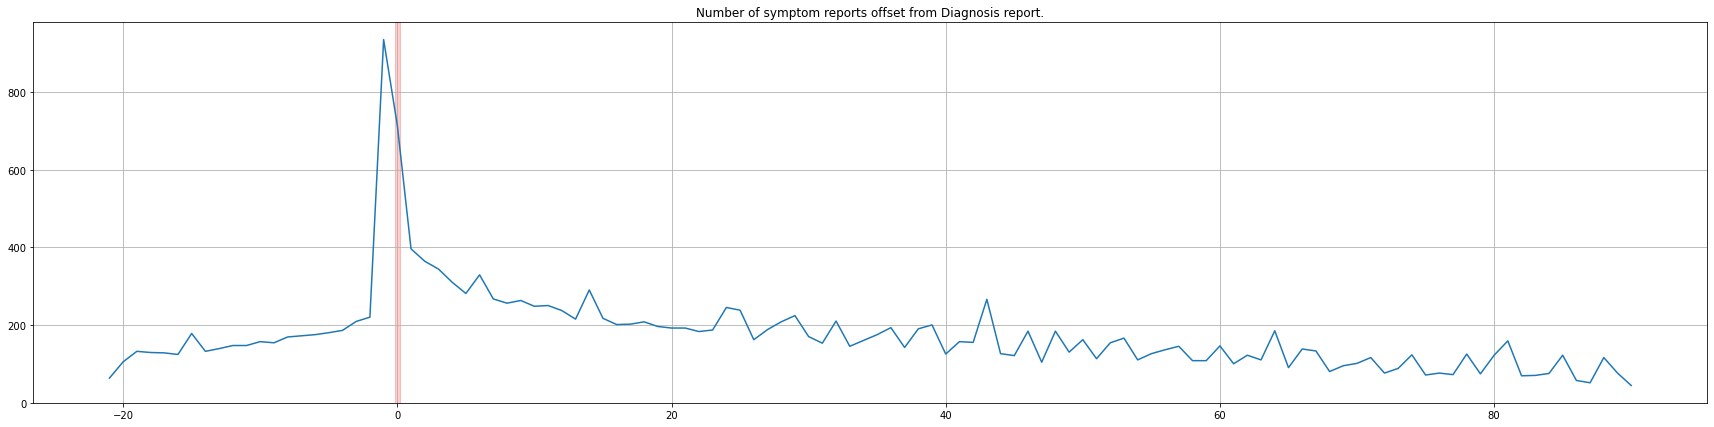

In [18]:
# plot count of symptoms
ax = diagnosis_symptom_agg['total'].plot(title='Number of symptom reports offset from Diagnosis report.', figsize=(30,7), grid=True)
ax.axvspan(-0.2, 0.2, alpha=0.2, color='r')

In [19]:
for col in ['cough','breathing','fever', 'smell', 'fatigue', 'muscle_joint_pain', 'headache', 'congestion', 'nausea', 'chills', 'confusion', 'mood_arousal', 'mood_valence']:
    diagnosis_symptom_agg[f"avg_{col}"] = diagnosis_symptom_agg[col] / diagnosis_symptom_agg['total']

In [20]:
display(diagnosis_symptom_agg)

,cough,breathing,fever,smell,fatigue,muscle_joint_pain,headache,congestion,nausea,chills,...,avg_smell,avg_fatigue,avg_muscle_joint_pain,avg_headache,avg_congestion,avg_nausea,avg_chills,avg_confusion,avg_mood_arousal,avg_mood_valence
-21,19.0,9.0,2.0,8.0,6.0,2.0,1.0,0.0,0.0,0.0,...,0.126984,0.095238,0.031746,0.015873,0.000000,0.000000,0.000000,0.000000,-0.015873,0.111111
-20,11.0,3.0,0.0,6.0,7.0,4.0,2.0,1.0,1.0,0.0,...,0.057143,0.066667,0.038095,0.019048,0.009524,0.009524,0.000000,0.000000,0.135714,0.200000
-19,26.0,8.0,2.0,10.0,9.0,5.0,6.0,8.0,2.0,0.0,...,0.075758,0.068182,0.037879,0.045455,0.060606,0.015152,0.000000,0.000000,0.181818,0.198864
-18,18.0,10.0,2.0,12.0,16.0,10.0,5.0,5.0,2.0,3.0,...,0.093023,0.124031,0.077519,0.038760,0.038760,0.015504,0.023256,0.007752,0.114341,0.143411
-17,32.0,13.0,4.0,15.0,13.0,11.0,6.0,4.0,1.0,0.0,...,0.117188,0.101562,0.085938,0.046875,0.031250,0.007812,0.000000,0.000000,0.058594,0.144531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,10.0,24.0,4.0,18.0,13.0,10.0,5.0,3.0,6.0,1.0,...,0.315789,0.228070,0.175439,0.087719,0.052632,0.105263,0.017544,0.035088,-0.026316,0.109649
87,14.0,27.0,2.0,24.0,14.0,10.0,6.0,6.0,2.0,0.0,...,0.470588,0.274510,0.196078,0.117647,0.117647,0.039216,0.000000,0.019608,-0.161765,0.000000
88,63.0,120.0,4.0,28.0,29.0,28.0,16.0,10.0,2.0,4.0,...,0.241379,0.250000,0.241379,0.137931,0.086207,0.017241,0.034483,0.034483,-0.379310,0.075431
89,23.0,30.0,5.0,24.0,30.0,18.0,13.0,7.0,5.0,9.0,...,0.315789,0.394737,0.236842,0.171053,0.092105,0.065789,0.118421,0.026316,0.062500,0.128289


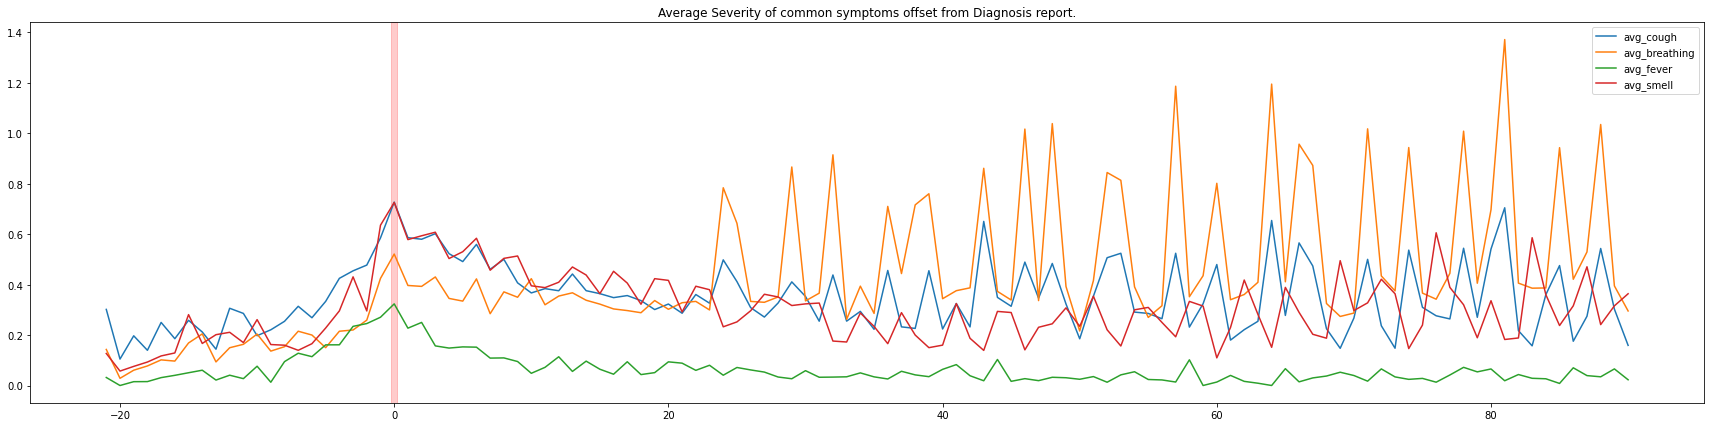

In [21]:
# Plot main symptoms
main_cols = ['avg_cough','avg_breathing','avg_fever', 'avg_smell']
ax = diagnosis_symptom_agg[main_cols].plot(title='Average Severity of common symptoms offset from Diagnosis report.', figsize=(30,7))
ax.axvspan(-0.2, 0.2, alpha=0.2, color='r')

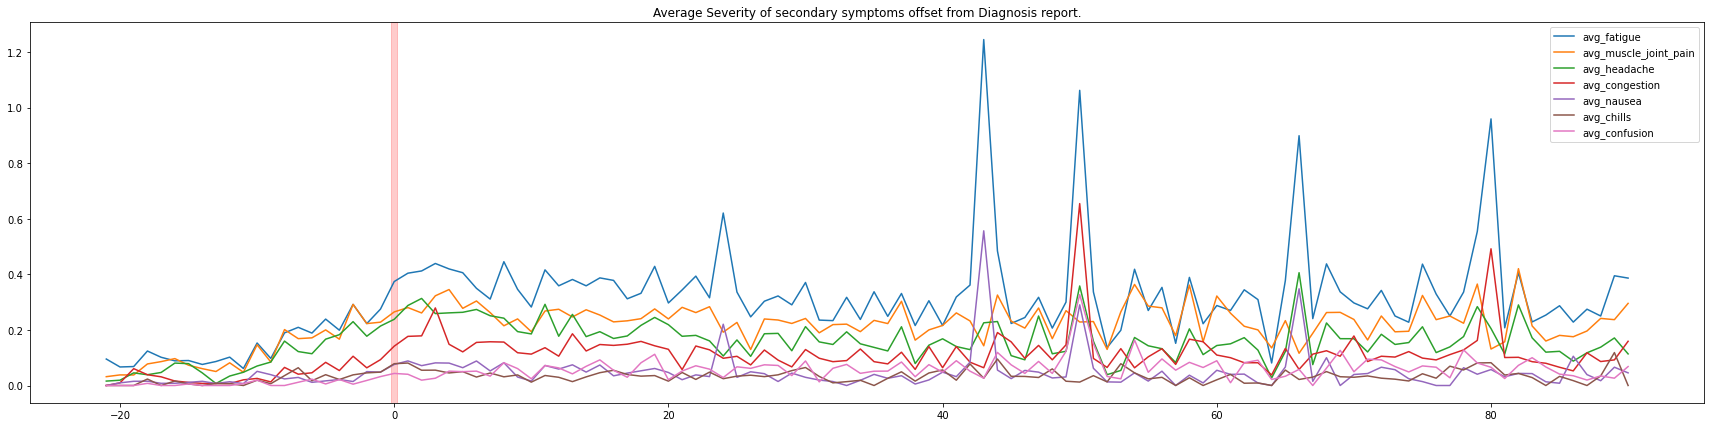

In [22]:
# Plot secondary symptoms
secondary_cols = ['avg_fatigue', 'avg_muscle_joint_pain', 'avg_headache', 'avg_congestion', 'avg_nausea', 'avg_chills', 'avg_confusion']
ax = diagnosis_symptom_agg[secondary_cols].plot(title='Average Severity of secondary symptoms offset from Diagnosis report.', figsize=(30,7))
ax.axvspan(-0.2, 0.2, alpha=0.2, color='r')

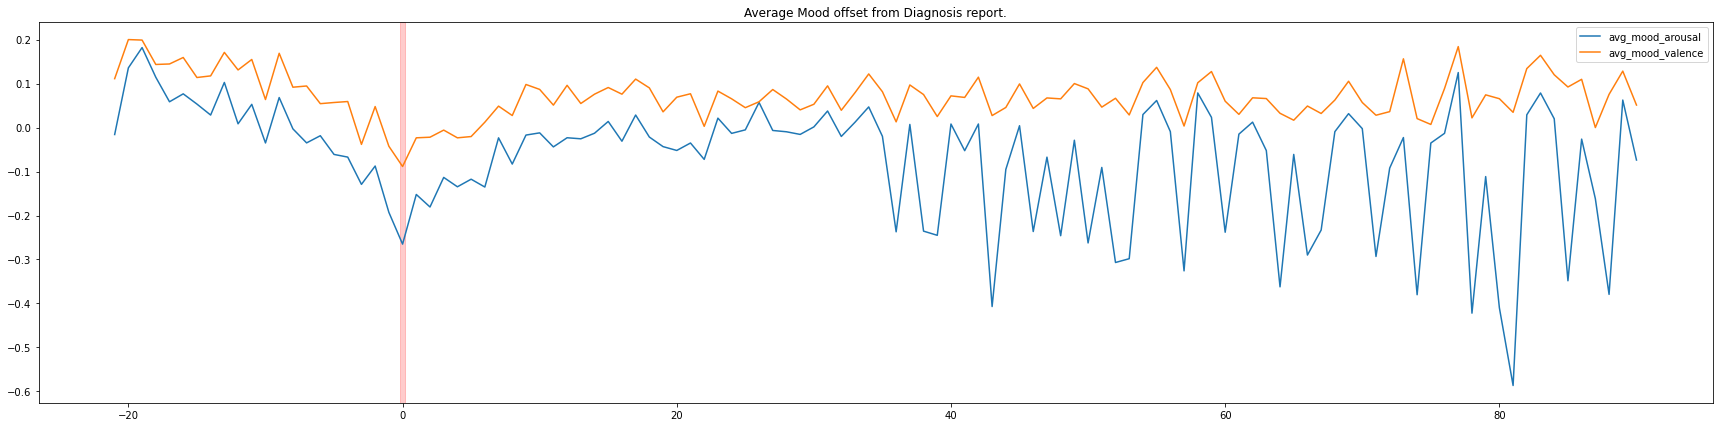

In [23]:
# Plot mood
mood_cols = ['avg_mood_arousal', 'avg_mood_valence']
ax = diagnosis_symptom_agg[mood_cols].plot(title='Average Mood offset from Diagnosis report.', figsize=(30,7))
ax.axvspan(-0.2, 0.2, alpha=0.2, color='r')

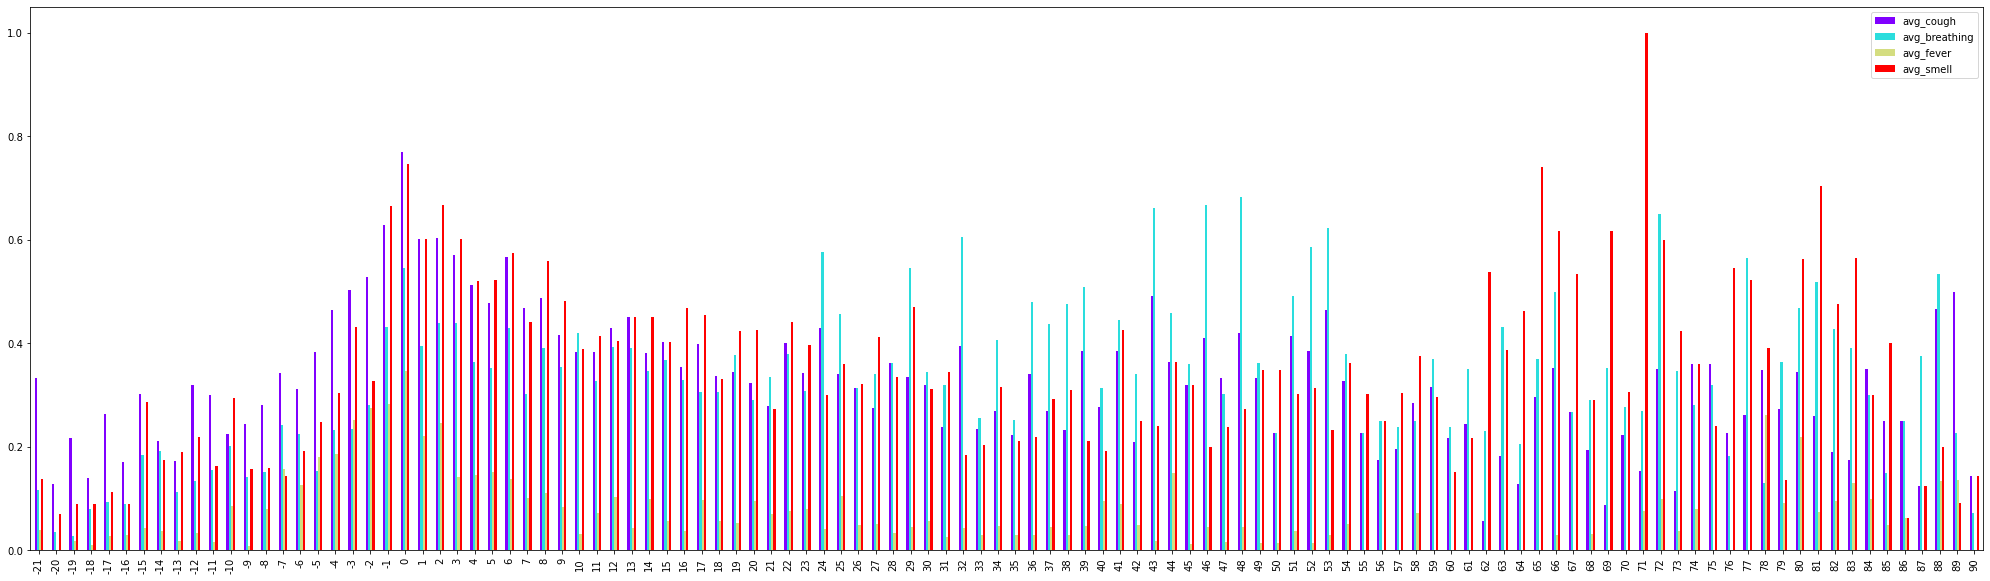

In [33]:
# Bar plots
ax = diagnosis_symptom_agg[main_cols].plot(kind='bar', colormap='rainbow', figsize=(35,10))

 #### Possible colormap values
    'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r',
    'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples',
    'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia',
    'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis',
    'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar',
    'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r',
    'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer',
    'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r',
    'winter', 'winter_r'

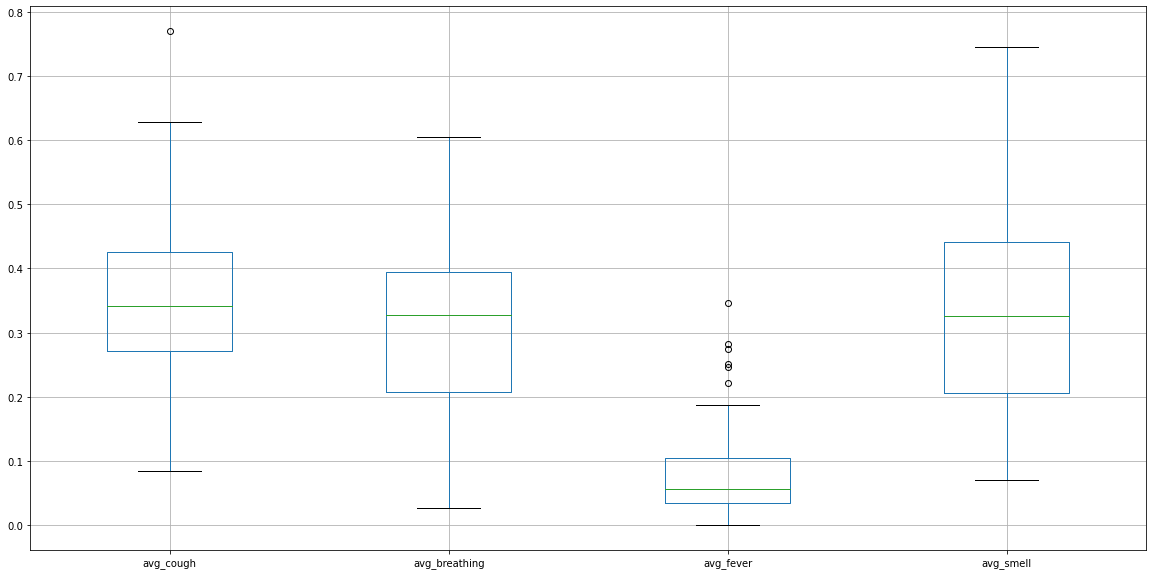

In [106]:
ax = diagnosis_symptom_agg[main_cols].boxplot(figsize=(20,10))

In [ ]:
# Group by users

In [ ]:
# Groupby covid diagnosis

In [ ]:
# Groupby symptoms and aggregate to counts

# Create venn diagram of all reported symptoms

In [17]:
map_cols = {
    'cough': 'task_symptoms_value_Cough',
    'breathing': 'task_symptoms_value_Difficulties breathing',
    'fever': 'task_symptoms_value_Fever',
    'smell': 'task_symptoms_value_Loss of sense of smell (anosmia)',
    'fatigue': 'task_symptoms_value_Fatigue'
}

for key, val in map_cols.items():
    symptoms_filtered[key] = symptoms_filtered[val].apply(lambda x: 1 if x > 0 else 0)

symptoms_filtered

,Unnamed: 0,pid,version,name,time_scheduled,time_received,time,time_start,id,task_mood_time_start,...,task_symptoms_value_Headache,task_symptoms_value_Congestion,task_symptoms_value_Nausea,task_symptoms_value_Chills,task_symptoms_value_Confusion,cough,breathing,fever,smell,fatigue
time,,,,,,,,,,,,,,,,,,,,,
2020-11-03 12:25:24.380000+00:00,193,symptoms,1,CoViD symptoms,NaN,2020-11-03 12:25:20.938000+00:00,2020-11-03 12:25:24.380000+00:00,2020-11-03 12:25:06.435000+00:00,02KIBYpUG9QJ9yL0w7fU1oHUysu1,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0
2020-10-18 20:39:24.957000+00:00,194,symptoms,1,CoViD symptoms,NaN,2020-10-18 20:39:23.830000+00:00,2020-10-18 20:39:24.957000+00:00,2020-10-18 20:39:13.561000+00:00,02KIBYpUG9QJ9yL0w7fU1oHUysu1,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
2020-11-05 10:11:26.093000+00:00,195,symptoms,1,CoViD symptoms,NaN,2020-11-05 10:11:21.946000+00:00,2020-11-05 10:11:26.093000+00:00,2020-11-05 10:11:14.060000+00:00,02KIBYpUG9QJ9yL0w7fU1oHUysu1,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
2020-10-28 17:07:54.955000+00:00,196,symptoms,1,CoViD symptoms,NaN,2020-10-28 17:07:51.222000+00:00,2020-10-28 17:07:54.955000+00:00,2020-10-28 17:07:45.169000+00:00,02KIBYpUG9QJ9yL0w7fU1oHUysu1,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0
2020-12-08 10:01:07+00:00,197,symptoms,1,CoViD symptoms,NaN,2020-12-08 10:01:00.120000+00:00,2020-12-08 10:01:07+00:00,2020-12-08 10:00:43.328000+00:00,02KIBYpUG9QJ9yL0w7fU1oHUysu1,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-14 10:57:49.517999+00:00,148493,symptoms,1,CoViD symptoms,NaN,2021-02-14 10:57:49.542000+00:00,2021-02-14 10:57:49.517999+00:00,2021-02-14 10:57:27.845000+00:00,zxqFEuyz9EfPOpoqgyKr2CJ8VGS2,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
2021-01-25 00:37:05.466000+00:00,148557,symptoms,2,Covid Symptoms,NaN,2021-01-25 00:37:02.386000+00:00,2021-01-25 00:37:05.466000+00:00,2021-01-25 00:36:46.547000+00:00,zzvksuOwiSNtBglkEr8z5nctTz53,NaN,...,1.0,NaN,NaN,NaN,NaN,0,1,0,1,0
2021-01-22 10:00:53.205000+00:00,148558,symptoms,2,Covid Symptoms,NaN,2021-01-22 10:00:50.351000+00:00,2021-01-22 10:00:53.205000+00:00,2021-01-22 10:00:10.691000+00:00,zzvksuOwiSNtBglkEr8z5nctTz53,NaN,...,2.0,2.0,NaN,NaN,NaN,1,1,0,0,0


In [18]:
symptoms_filtered['cough'] & symptoms_filtered['breathing']

time
2020-11-03 12:25:24.380000+00:00    0
2020-10-18 20:39:24.957000+00:00    0
2020-11-05 10:11:26.093000+00:00    0
2020-10-28 17:07:54.955000+00:00    0
2020-12-08 10:01:07+00:00           0
                                   ..
2021-02-14 10:57:49.517999+00:00    0
2021-01-25 00:37:05.466000+00:00    0
2021-01-22 10:00:53.205000+00:00    1
2021-01-21 22:56:12.777000+00:00    1
2021-01-23 13:12:17.625000+00:00    0
Length: 7926, dtype: int64

In [19]:
list_keys = list(map_cols.keys())
for idx1, key1 in enumerate(map_cols.keys()):
    for idx2, key2 in enumerate(map_cols.keys()):
        if key1 != key2 and idx2 > idx1:
            list_keys.append(f"{key1}_{key2}")
            symptoms_filtered[f"{key1}_{key2}"] = symptoms_filtered[key1] & symptoms_filtered[key2]
            for idx3, key3 in enumerate(map_cols.keys()):
                if idx3 > idx2:
                    list_keys.append(f"{key1}_{key2}_{key3}")
                    symptoms_filtered[f"{key1}_{key2}_{key3}"] = symptoms_filtered[key1] & symptoms_filtered[key2] & symptoms_filtered[key3]
symptoms_filtered

,Unnamed: 0,pid,version,name,time_scheduled,time_received,time,time_start,id,task_mood_time_start,...,breathing_fever,breathing_fever_smell,breathing_fever_fatigue,breathing_smell,breathing_smell_fatigue,breathing_fatigue,fever_smell,fever_smell_fatigue,fever_fatigue,smell_fatigue
time,,,,,,,,,,,,,,,,,,,,,
2020-11-03 12:25:24.380000+00:00,193,symptoms,1,CoViD symptoms,NaN,2020-11-03 12:25:20.938000+00:00,2020-11-03 12:25:24.380000+00:00,2020-11-03 12:25:06.435000+00:00,02KIBYpUG9QJ9yL0w7fU1oHUysu1,NaN,...,0,0,0,0,0,0,0,0,0,0
2020-10-18 20:39:24.957000+00:00,194,symptoms,1,CoViD symptoms,NaN,2020-10-18 20:39:23.830000+00:00,2020-10-18 20:39:24.957000+00:00,2020-10-18 20:39:13.561000+00:00,02KIBYpUG9QJ9yL0w7fU1oHUysu1,NaN,...,0,0,0,0,0,0,0,0,0,0
2020-11-05 10:11:26.093000+00:00,195,symptoms,1,CoViD symptoms,NaN,2020-11-05 10:11:21.946000+00:00,2020-11-05 10:11:26.093000+00:00,2020-11-05 10:11:14.060000+00:00,02KIBYpUG9QJ9yL0w7fU1oHUysu1,NaN,...,0,0,0,0,0,0,0,0,0,0
2020-10-28 17:07:54.955000+00:00,196,symptoms,1,CoViD symptoms,NaN,2020-10-28 17:07:51.222000+00:00,2020-10-28 17:07:54.955000+00:00,2020-10-28 17:07:45.169000+00:00,02KIBYpUG9QJ9yL0w7fU1oHUysu1,NaN,...,0,0,0,0,0,0,0,0,0,0
2020-12-08 10:01:07+00:00,197,symptoms,1,CoViD symptoms,NaN,2020-12-08 10:01:00.120000+00:00,2020-12-08 10:01:07+00:00,2020-12-08 10:00:43.328000+00:00,02KIBYpUG9QJ9yL0w7fU1oHUysu1,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-14 10:57:49.517999+00:00,148493,symptoms,1,CoViD symptoms,NaN,2021-02-14 10:57:49.542000+00:00,2021-02-14 10:57:49.517999+00:00,2021-02-14 10:57:27.845000+00:00,zxqFEuyz9EfPOpoqgyKr2CJ8VGS2,NaN,...,0,0,0,0,0,0,0,0,0,0
2021-01-25 00:37:05.466000+00:00,148557,symptoms,2,Covid Symptoms,NaN,2021-01-25 00:37:02.386000+00:00,2021-01-25 00:37:05.466000+00:00,2021-01-25 00:36:46.547000+00:00,zzvksuOwiSNtBglkEr8z5nctTz53,NaN,...,0,0,0,1,0,0,0,0,0,0
2021-01-22 10:00:53.205000+00:00,148558,symptoms,2,Covid Symptoms,NaN,2021-01-22 10:00:50.351000+00:00,2021-01-22 10:00:53.205000+00:00,2021-01-22 10:00:10.691000+00:00,zzvksuOwiSNtBglkEr8z5nctTz53,NaN,...,0,0,0,0,0,0,0,0,0,0


In [20]:
len(list_keys)

25

In [21]:
days_before = 20
days_after = 40
columns = list(list_keys)
columns.append('total')
import numpy as np
data = np.zeros(shape=(days_before+days_after+2, len(columns)))
cluster_symptom_agg = pd.DataFrame(data, index =list(range(-days_before-1,days_after+1)), columns=columns)

total = 0
for index, row in diagnosis_filtered[['id', 'task_date_illness_value']].iterrows():
    if pd.notnull(row['task_date_illness_value']):
        index = pd.to_datetime(row['task_date_illness_value'], infer_datetime_format=True)
    window_start = (index - pd.Timedelta(days_before, 'days')).strftime('%Y-%m-%d')
    window_end = (index + pd.Timedelta(days_after, 'days')).strftime('%Y-%m-%d')
    for idx, symptom in symptoms_filtered[symptoms_filtered['id'] == row['id']].loc[window_start:window_end].iterrows():
            symptom = symptom.fillna(0)
            day = (idx - index).days
            
            for key in list_keys:
                cluster_symptom_agg.loc[day, key] += symptom[key]
            
            total += 1
            cluster_symptom_agg.loc[day, 'total'] += 1
            print(f'progress: {total}', end='\x1b[1K\r')

display(cluster_symptom_agg)

,cough,breathing,fever,smell,fatigue,cough_breathing,cough_breathing_fever,cough_breathing_smell,cough_breathing_fatigue,cough_fever,...,breathing_fever_smell,breathing_fever_fatigue,breathing_smell,breathing_smell_fatigue,breathing_fatigue,fever_smell,fever_smell_fatigue,fever_fatigue,smell_fatigue,total
-21,13.0,5.0,2.0,5.0,2.0,5.0,1.0,4.0,0.0,2.0,...,1.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,0.0,51.0
-20,11.0,3.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,86.0
-19,22.0,3.0,2.0,5.0,5.0,2.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,111.0
-18,11.0,8.0,1.0,3.0,4.0,5.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,100.0
-17,25.0,9.0,2.0,5.0,8.0,5.0,2.0,1.0,2.0,2.0,...,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,29.0,27.0,2.0,14.0,15.0,21.0,2.0,2.0,4.0,2.0,...,0.0,1.0,7.0,4.0,6.0,0.0,0.0,1.0,8.0,100.0
37,18.0,26.0,2.0,15.0,15.0,14.0,1.0,2.0,7.0,1.0,...,0.0,1.0,7.0,4.0,12.0,0.0,0.0,1.0,4.0,89.0
38,19.0,30.0,3.0,18.0,13.0,9.0,1.0,3.0,4.0,3.0,...,1.0,1.0,9.0,5.0,6.0,3.0,1.0,1.0,5.0,103.0
39,35.0,33.0,4.0,14.0,16.0,24.0,2.0,2.0,5.0,2.0,...,1.0,4.0,7.0,3.0,11.0,1.0,1.0,4.0,3.0,104.0


In [22]:
sums = cluster_symptom_agg.sum()

In [23]:
sums

cough                       3640.0
breathing                   2701.0
fever                        987.0
smell                       2336.0
fatigue                     1700.0
cough_breathing             1880.0
cough_breathing_fever        535.0
cough_breathing_smell        734.0
cough_breathing_fatigue      662.0
cough_fever                  787.0
cough_fever_smell            399.0
cough_fever_fatigue          249.0
cough_smell                 1359.0
cough_smell_fatigue          354.0
cough_fatigue                907.0
breathing_fever              597.0
breathing_fever_smell        286.0
breathing_fever_fatigue      216.0
breathing_smell             1102.0
breathing_smell_fatigue      320.0
breathing_fatigue            841.0
fever_smell                  433.0
fever_smell_fatigue          117.0
fever_fatigue                342.0
smell_fatigue                546.0
total                      10564.0
dtype: float64

In [24]:
from matplotlib_venn import venn3
from matplotlib import pyplot as plt

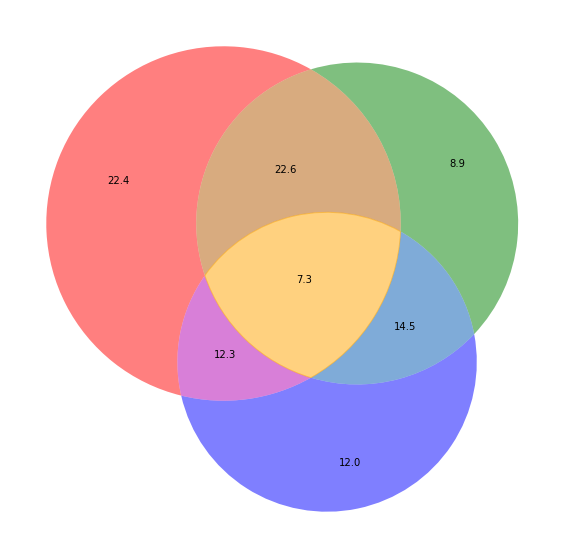

In [25]:
a, b, c = ('cough', 'breathing', 'smell')


venn_101 = sums[f"{a}_{c}"] - sums[f"{a}_{b}_{c}"]
venn_011 = sums[f"{b}_{c}"] - sums[f"{a}_{b}_{c}"]
venn_110 = sums[f"{a}_{b}"] - sums[f"{a}_{b}_{c}"]
venn_111 = sums[f"{a}_{b}_{c}"]

venn_100 = sums[a] - venn_110 - venn_101 - venn_111
venn_010 = sums[b] - venn_110 - venn_011 - venn_111
venn_001 = sums[c] - venn_101 - venn_011 - venn_111

total = venn_100 + venn_010 + venn_001 + venn_101 + venn_111 + venn_011 + venn_110


def calc_perc(v):
    return (v/total*100).round(1)

plt.figure(figsize=(10,10))
out = venn3(subsets = (calc_perc(venn_100), calc_perc(venn_010), calc_perc(venn_110), calc_perc(venn_001), calc_perc(venn_101), calc_perc(venn_111), calc_perc(venn_011)), set_labels = (a, b, c), alpha = 0.5);
out.get_patch_by_id('111').set_color('orange')
for text in out.set_labels:
    text.set_color("white")

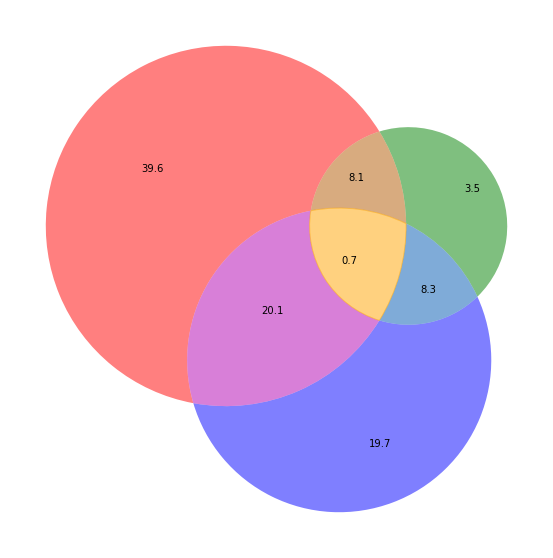

In [26]:
a, b, c = ('cough', 'fever', 'smell')


venn_101 = sums[f"{a}_{c}"] - sums[f"{a}_{b}_{c}"]
venn_011 = sums[f"{b}_{c}"] - sums[f"{a}_{b}_{c}"]
venn_110 = sums[f"{a}_{b}"] - sums[f"{a}_{b}_{c}"]
venn_111 = sums[f"{a}_{b}_{c}"]

venn_100 = sums[a] - venn_110 - venn_101 - venn_111
venn_010 = sums[b] - venn_110 - venn_011 - venn_111
venn_001 = sums[c] - venn_101 - venn_011 - venn_111

total = venn_100 + venn_010 + venn_001 + venn_101 + venn_111 + venn_011 + venn_110


def calc_perc(v):
    return (v/total*100).round(1)

plt.figure(figsize=(10,10))
out = venn3(subsets = (calc_perc(venn_100), calc_perc(venn_010), calc_perc(venn_110), calc_perc(venn_001), calc_perc(venn_101), calc_perc(venn_111), calc_perc(venn_011)), set_labels = (a, b, c), alpha = 0.5);
out.get_patch_by_id('111').set_color('orange')
for text in out.set_labels:
    text.set_color("white")

In [27]:
diag_day = cluster_symptom_agg.loc[0:1].sum()

In [28]:
diag_day

cough                      526.0
breathing                  363.0
fever                      212.0
smell                      329.0
fatigue                    195.0
cough_breathing            280.0
cough_breathing_fever      119.0
cough_breathing_smell      127.0
cough_breathing_fatigue     75.0
cough_fever                176.0
cough_fever_smell           81.0
cough_fever_fatigue         48.0
cough_smell                234.0
cough_smell_fatigue         51.0
cough_fatigue              114.0
breathing_fever            129.0
breathing_fever_smell       63.0
breathing_fever_fatigue     42.0
breathing_smell            165.0
breathing_smell_fatigue     40.0
breathing_fatigue           99.0
fever_smell                 86.0
fever_smell_fatigue         20.0
fever_fatigue               66.0
smell_fatigue               77.0
total                      951.0
dtype: float64

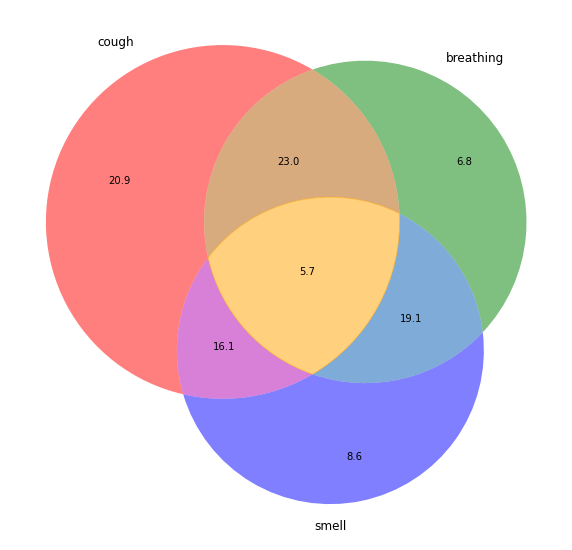

In [35]:
a, b, c = ('cough', 'breathing', 'smell')


venn_101 = diag_day[f"{a}_{c}"] - diag_day[f"{a}_{b}_{c}"]
venn_011 = diag_day[f"{b}_{c}"] - diag_day[f"{a}_{b}_{c}"]
venn_110 = diag_day[f"{a}_{b}"] - diag_day[f"{a}_{b}_{c}"]
venn_111 = diag_day[f"{a}_{b}_{c}"]

venn_100 = diag_day[a] - venn_110 - venn_101 - venn_111
venn_010 = diag_day[b] - venn_110 - venn_011 - venn_111
venn_001 = diag_day[c] - venn_101 - venn_011 - venn_111

total = venn_100 + venn_010 + venn_001 + venn_101 + venn_111 + venn_011 + venn_110


def calc_perc(v):
    return (v/total*100).round(1)

plt.figure(figsize=(10,10))
out = venn3(subsets = (calc_perc(venn_100), calc_perc(venn_010), calc_perc(venn_110), calc_perc(venn_001), calc_perc(venn_101), calc_perc(venn_111), calc_perc(venn_011)), set_labels = (a, b, c), alpha = 0.5);
out.get_patch_by_id('111').set_color('orange')
for text in out.set_labels:
    text.set_color("black")

In [32]:
infection_period = cluster_symptom_agg.loc[-10:10].sum()

In [33]:
infection_period

cough                      2238.0
breathing                  1505.0
fever                       776.0
smell                      1364.0
fatigue                     912.0
cough_breathing            1105.0
cough_breathing_fever       397.0
cough_breathing_smell       497.0
cough_breathing_fatigue     343.0
cough_fever                 618.0
cough_fever_smell           316.0
cough_fever_fatigue         173.0
cough_smell                 916.0
cough_smell_fatigue         217.0
cough_fatigue               498.0
breathing_fever             444.0
breathing_fever_smell       223.0
breathing_fever_fatigue     141.0
breathing_smell             670.0
breathing_smell_fatigue     170.0
breathing_fatigue           427.0
fever_smell                 341.0
fever_smell_fatigue          91.0
fever_fatigue               256.0
smell_fatigue               303.0
total                      5267.0
dtype: float64

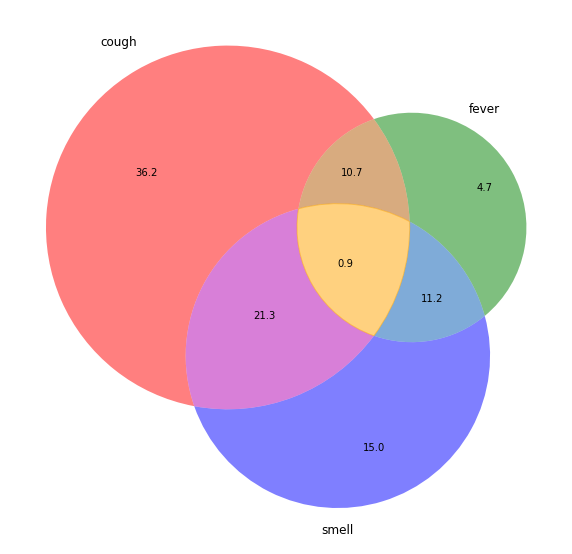

In [34]:
a, b, c = ('cough', 'fever', 'smell')


venn_101 = infection_period[f"{a}_{c}"] - infection_period[f"{a}_{b}_{c}"]
venn_011 = infection_period[f"{b}_{c}"] - infection_period[f"{a}_{b}_{c}"]
venn_110 = infection_period[f"{a}_{b}"] - infection_period[f"{a}_{b}_{c}"]
venn_111 = infection_period[f"{a}_{b}_{c}"]

venn_100 = infection_period[a] - venn_110 - venn_101 - venn_111
venn_010 = infection_period[b] - venn_110 - venn_011 - venn_111
venn_001 = infection_period[c] - venn_101 - venn_011 - venn_111

total = venn_100 + venn_010 + venn_001 + venn_101 + venn_111 + venn_011 + venn_110


def calc_perc(v):
    return (v/total*100).round(1)

plt.figure(figsize=(10,10))
out = venn3(subsets = (calc_perc(venn_100), calc_perc(venn_010), calc_perc(venn_110), calc_perc(venn_001), calc_perc(venn_101), calc_perc(venn_111), calc_perc(venn_011)), set_labels = (a, b, c), alpha = 0.5);
out.get_patch_by_id('111').set_color('orange')
for text in out.set_labels:
    text.set_color("black")

In [45]:
212/951

0.22292323869610936